In [3]:
#https://www.kaggle.com/datasets/deepaksirohiwal/delhi-air-quality
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


In [5]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, max, min, count, to_date
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Create a Spark session
spark = SparkSession.builder.appName("delhi_aqi").getOrCreate()

In [7]:
# Set dataset path (update this with the actual path)
dataset_path = "delhi_aqi.csv"

In [8]:
# Load dataset
df = spark.read.csv(dataset_path, header=True, inferSchema=True)

In [9]:
# Show first 5 rows
df.show(5)

+-------------------+-------+-----+------+-----+-----+------+------+-----+
|               date|     co|   no|   no2|   o3|  so2| pm2_5|  pm10|  nh3|
+-------------------+-------+-----+------+-----+-----+------+------+-----+
|2020-11-25 01:00:00|2616.88| 2.18|  70.6|13.59|38.62|364.61|411.73|28.63|
|2020-11-25 02:00:00|3631.59|23.25| 89.11| 0.33|54.36|420.96|486.21|41.04|
|2020-11-25 03:00:00|4539.49|52.75|100.08| 1.11|68.67|463.68|541.95|49.14|
|2020-11-25 04:00:00|4539.49|50.96|111.04| 6.44| 78.2|454.81| 534.0|48.13|
|2020-11-25 05:00:00|4379.27|42.92| 117.9|17.17|87.74|448.14|529.19|46.61|
+-------------------+-------+-----+------+-----+-----+------+------+-----+
only showing top 5 rows



In [39]:
df.head(5)

[Row(date=datetime.date(2020, 11, 25), co=2616.88, no=2.18, no2=70.6, o3=13.59, so2=38.62, pm2_5=364.61, pm10=411.73, nh3=28.63, AQI_Category='Very Unhealthy'),
 Row(date=datetime.date(2020, 11, 25), co=3631.59, no=23.25, no2=89.11, o3=0.33, so2=54.36, pm2_5=420.96, pm10=486.21, nh3=41.04, AQI_Category='Hazardous'),
 Row(date=datetime.date(2020, 11, 25), co=4539.49, no=52.75, no2=100.08, o3=1.11, so2=68.67, pm2_5=463.68, pm10=541.95, nh3=49.14, AQI_Category='Hazardous'),
 Row(date=datetime.date(2020, 11, 25), co=4539.49, no=50.96, no2=111.04, o3=6.44, so2=78.2, pm2_5=454.81, pm10=534.0, nh3=48.13, AQI_Category='Hazardous'),
 Row(date=datetime.date(2020, 11, 25), co=4379.27, no=42.92, no2=117.9, o3=17.17, so2=87.74, pm2_5=448.14, pm10=529.19, nh3=46.61, AQI_Category='Hazardous')]

In [10]:
# Print dataset schema
df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- co: double (nullable = true)
 |-- no: double (nullable = true)
 |-- no2: double (nullable = true)
 |-- o3: double (nullable = true)
 |-- so2: double (nullable = true)
 |-- pm2_5: double (nullable = true)
 |-- pm10: double (nullable = true)
 |-- nh3: double (nullable = true)



In [11]:
# Get total number of rows
print(f"Total records: {df.count()}")

Total records: 18776


In [ ]:
# Get summary statistics of numerical columns
df.describe().show()

+-------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+--------------+
|summary|                co|               no|               no2|               o3|              so2|             pm2_5|              pm10|               nh3|  AQI_Category|
+-------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+--------------+
|  count|             18776|            18776|             18776|            18776|            18776|             18776|             18776|             18776|         18776|
|   mean|2929.2286275032225|33.66070195994916|   66.221298998722|60.34623934810406|66.69363282914416|238.13030890498518|300.09296602045157| 25.10981518960385|          NULL|
| stddev|2854.5235056532933|62.12711802202761|48.527491992637245|80.46493196439782|49.43919077821275|226.53362509392468|267.165826

In [40]:
df.columns

['date',
 'co',
 'no',
 'no2',
 'o3',
 'so2',
 'pm2_5',
 'pm10',
 'nh3',
 'AQI_Category']

In [12]:
# Drop rows where all values are null
df = df.dropna(how="all")

In [13]:
# Fill missing values with column mean (for numeric data)
numeric_cols = ['pm2_5', 'pm10', 'no2', 'so2', 'co', 'o3']
for col_name in numeric_cols:
    mean_val = df.select(mean(col(col_name))).collect()[0][0]
    df = df.fillna({col_name: mean_val})

In [15]:
# Verify missing values are handled
df.select([count(col(c)).alias(c) for c in df.columns]).show()

+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| date|   co|   no|  no2|   o3|  so2|pm2_5| pm10|  nh3|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|18776|18776|18776|18776|18776|18776|18776|18776|18776|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+



In [16]:
df = df.withColumn("date", to_date(col("date")))

In [17]:
# Show transformed data
df.select("date").show(5)

+----------+
|      date|
+----------+
|2020-11-25|
|2020-11-25|
|2020-11-25|
|2020-11-25|
|2020-11-25|
+----------+
only showing top 5 rows



In [18]:
# Convert to Pandas for visualization
df_pandas = df.select("date", "pm2_5", "pm10", "no2", "so2", "co", "o3").toPandas()

In [19]:
# Set date as index
df_pandas.set_index("date", inplace=True)

<Figure size 1200x600 with 0 Axes>

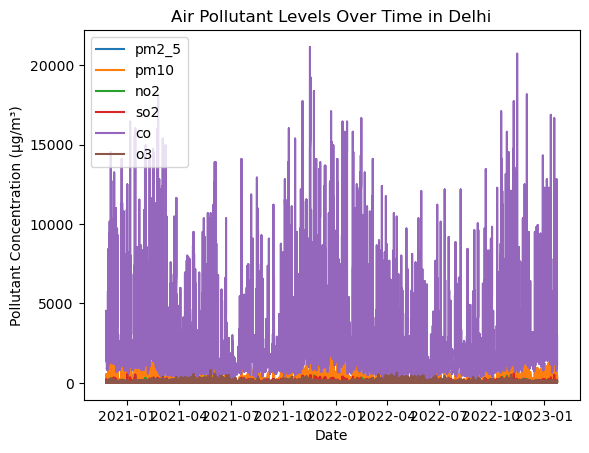

In [20]:
# Plot pollutant trends
plt.figure(figsize=(12,6))
df_pandas.plot(kind="line", linewidth=1.5)
plt.title("Air Pollutant Levels Over Time in Delhi")
plt.xlabel("Date")
plt.ylabel("Pollutant Concentration (µg/m³)")
plt.legend()
plt.show()

In [21]:
# Compute average pollutant levels
avg_pollutants = df.select([mean(col(c)).alias(c) for c in numeric_cols])
avg_pollutants.show()


+------------------+------------------+---------------+-----------------+------------------+-----------------+
|             pm2_5|              pm10|            no2|              so2|                co|               o3|
+------------------+------------------+---------------+-----------------+------------------+-----------------+
|238.13030890498518|300.09296602045157|66.221298998722|66.69363282914416|2929.2286275032225|60.34623934810406|
+------------------+------------------+---------------+-----------------+------------------+-----------------+



In [ ]:
#Normalize/Scale pollutant values (If required for ML models)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_pandas.iloc[:, 1:] = scaler.fit_transform(df_pandas.iloc[:, 1:])

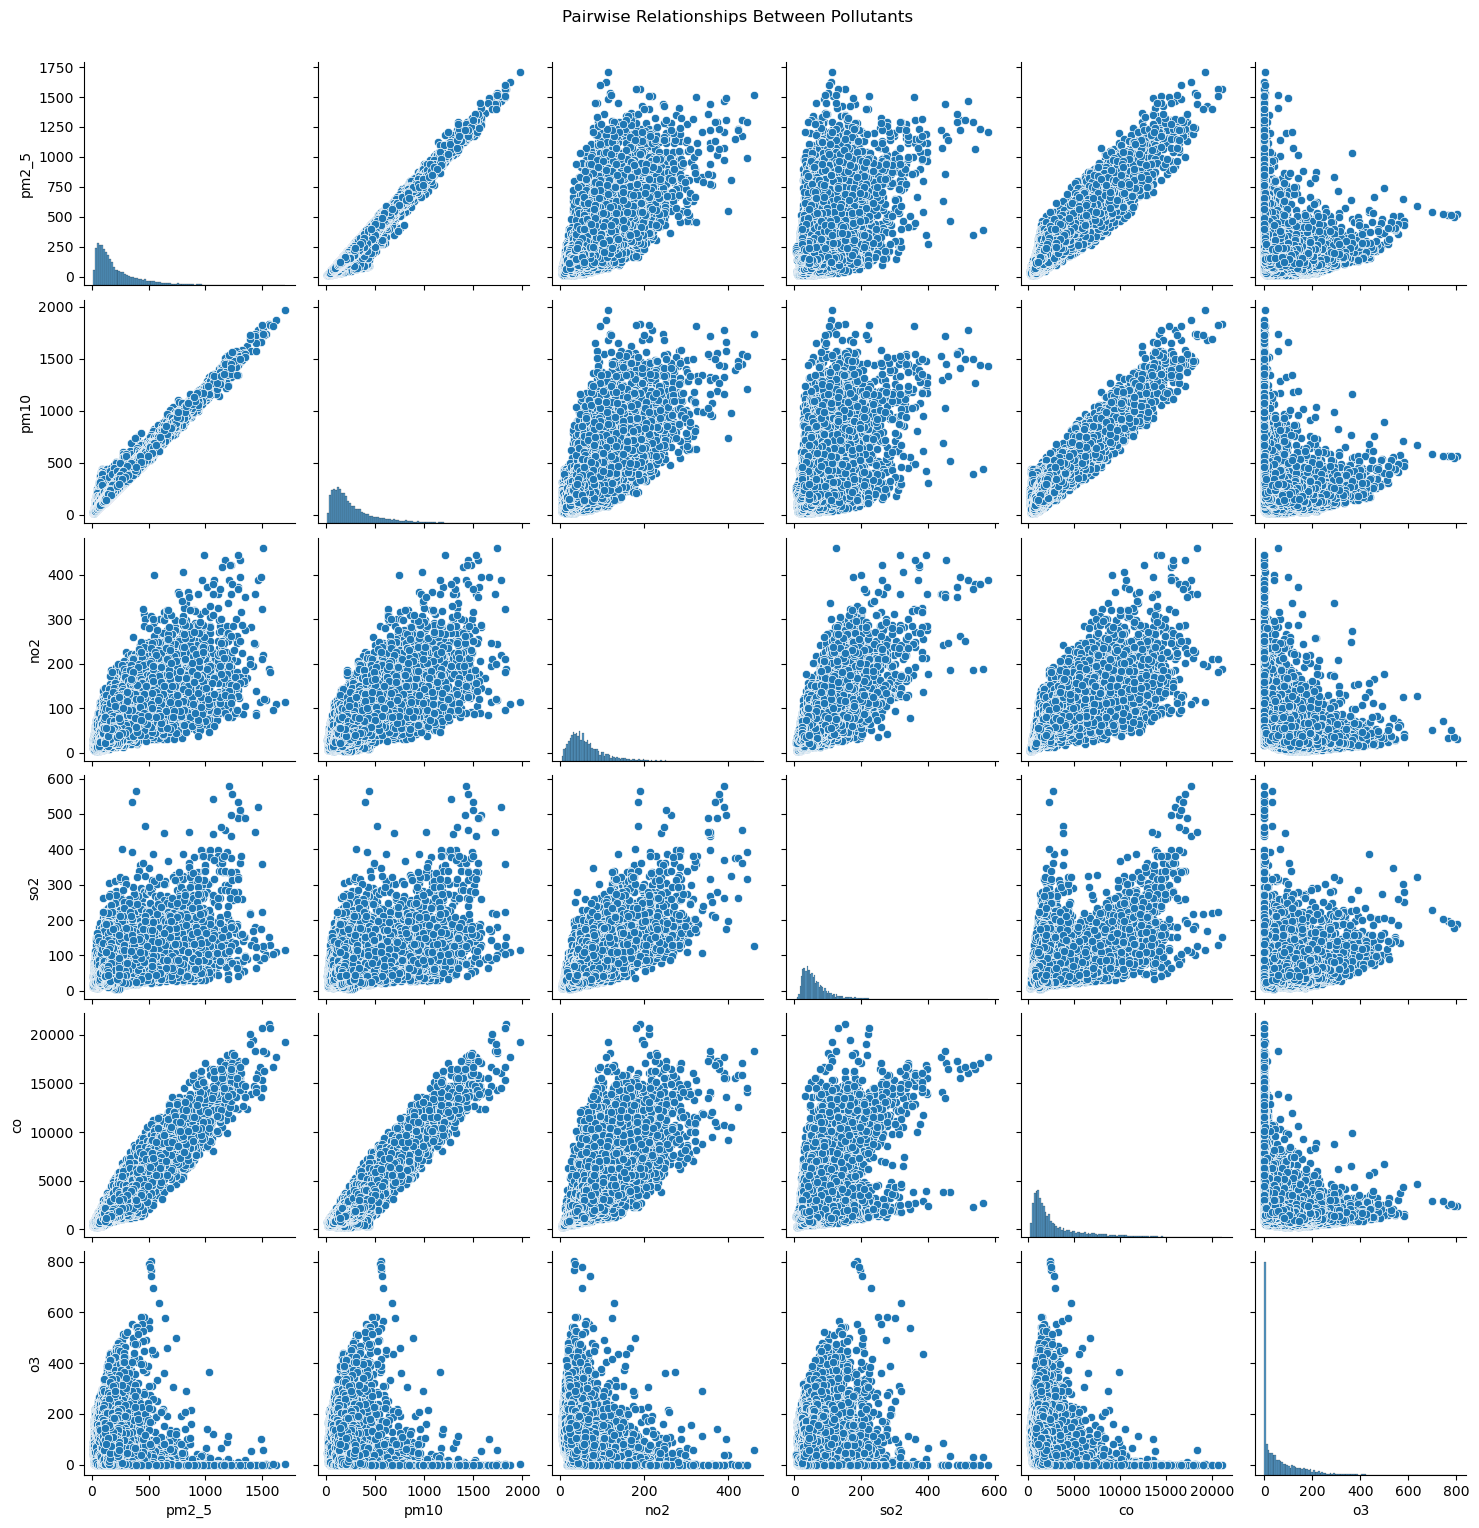

In [33]:
import seaborn as sns

sns.pairplot(df_pandas)
plt.suptitle("Pairwise Relationships Between Pollutants", y=1.02)
plt.show()


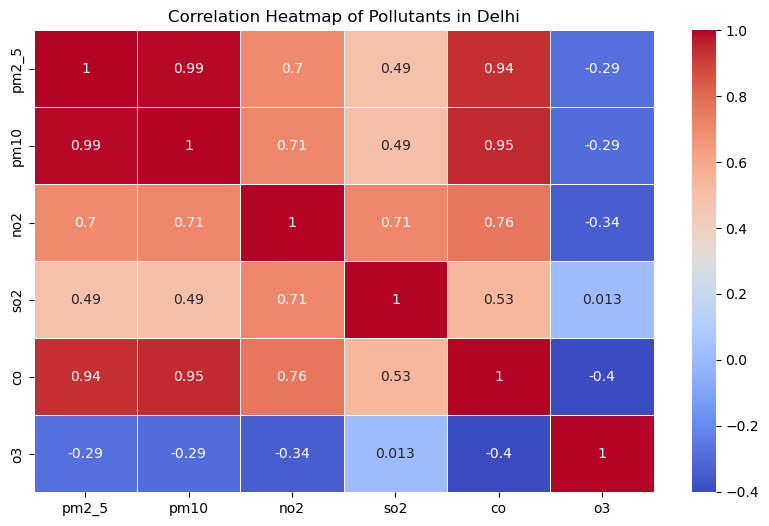

In [34]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_pandas.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Pollutants in Delhi")
plt.show()

<Figure size 1200x600 with 0 Axes>

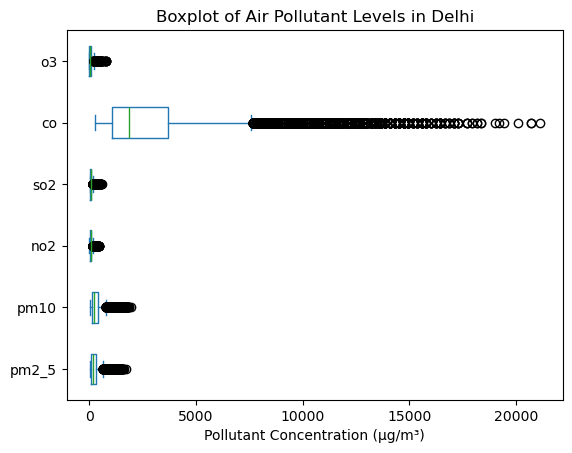

In [35]:
plt.figure(figsize=(12, 6))
df_pandas.plot(kind="box", vert=False)
plt.title("Boxplot of Air Pollutant Levels in Delhi")
plt.xlabel("Pollutant Concentration (µg/m³)")
plt.show()

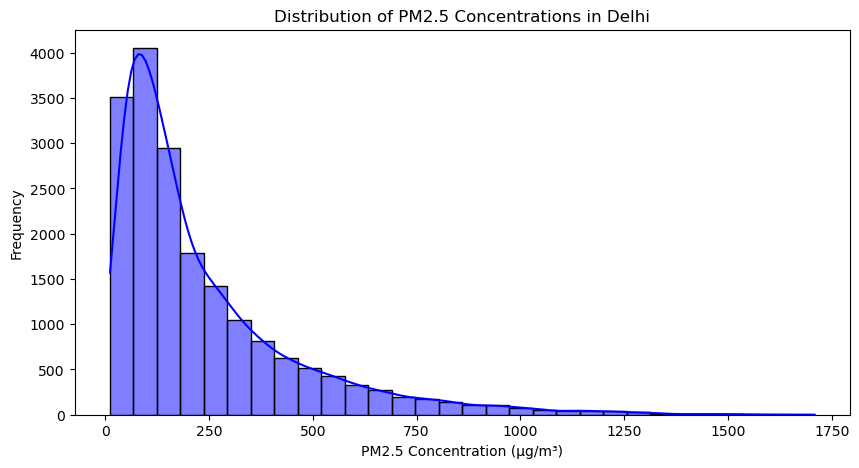

In [36]:
plt.figure(figsize=(10, 5))
sns.histplot(df_pandas["pm2_5"], kde=True, bins=30, color='blue')
plt.title("Distribution of PM2.5 Concentrations in Delhi")
plt.xlabel("PM2.5 Concentration (µg/m³)")
plt.ylabel("Frequency")
plt.show()

C:\Users\Dhriti\AppData\Local\Temp\ipykernel_16448\4188008993.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_pandas.resample('M').mean()


<Figure size 1200x600 with 0 Axes>

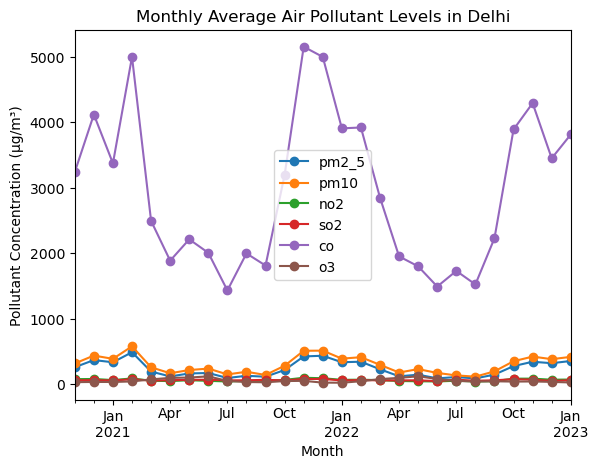

In [37]:
df_pandas.index = pd.to_datetime(df_pandas.index)  # Ensure date is in datetime format
monthly_avg = df_pandas.resample('M').mean()

plt.figure(figsize=(12, 6))
monthly_avg.plot(marker="o")
plt.title("Monthly Average Air Pollutant Levels in Delhi")
plt.xlabel("Month")
plt.ylabel("Pollutant Concentration (µg/m³)")
plt.legend()
plt.show()

In [43]:
print(df_pandas.isnull().sum())  # Check missing values


pm2_5    0
pm10     0
no2      0
so2      0
co       0
o3       0
dtype: int64


In [44]:
df_pandas.fillna(method='ffill', inplace=True)  # Forward fill missing values


C:\Users\Dhriti\AppData\Local\Temp\ipykernel_16448\161391600.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pandas.fillna(method='ffill', inplace=True)  # Forward fill missing values


In [45]:
print(df_pandas.duplicated().sum())  # Count duplicate rows

0
